# Exploration of a TMDB with approx. 5000 movies.

In [2]:
##My import cell
%matplotlib inline
import re
import requests
import textblob
import string
from datetime import datetime,date
import random
from scipy.misc import imread
from wordcloud import *
import os
import numpy as np
from collections import Counter
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import seaborn as sbn
import math
from nltk.corpus import stopwords
import textatistic
from bs4 import BeautifulSoup
from subprocess import check_output
matplotlib.style.use('ggplot')
import psycopg2
py.offline.init_notebook_mode()

In [3]:
py.version

<module 'plotly.version' from '/usr/local/lib/python3.5/site-packages/plotly/version.py'>

In [4]:
##Read in my two csv files from Kaggle
credits = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies.csv')

In [5]:
##Just checking to see the format

credits.head()
#credits.info()

movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

In [6]:
##Just checking to see the format

movies.head()
#movies.info()

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...                en   
4  [{"id": 818, "name": "based on novel"}, {"id":...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   
3  [{"name": "Legendary Pictures", "id": 923}, {"...   
4        [{"name": "Walt Disney Pictures", "id": 2}]   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   880674609   
3  [{"iso_3166_1": "US", "name": "United States o...   2012-07-16  1084939099   
4  [{"iso_3166_1": "US", "name": "United States o...   2012-03-07   284139100   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   
3    165.0           [{"iso_639_1": "en", "name": "English"}]  Released   
4    132.0           [{"iso_639_1": "en", "name": "English"}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                      title  vote_average  vote_count  
0                                    Avatar           7.2       11800  
1  Pirates of the Caribbean: At World's End           6.9        4500  
2                                   Spectre           6.3        4466  
3                     The Dark Knight Rises           7.6        9106  
4                               John Carter           6.1        2124

In [7]:
##Need to merge the two dataframes

whole1 = pd.merge(credits,movies, left_index=True, right_index=True)

In [8]:
##Delete a few repeat columns. Only runs once

del whole1['movie_id']

In [9]:
##Instead of having different title columns. I'm making sure we have one column with titles throughout the entire thing.

whole1 = whole1.rename(columns = {'title_x':'title'})

In [10]:
##Creating a new, more neat dataframe with the columns in the order that I want.

whole2 = whole1[['title','tagline','overview','runtime','id','budget','revenue','status','vote_average','vote_count','cast','keywords','genres','status','release_date','spoken_languages','original_language','production_countries','production_companies','crew','homepage']]
#whole2.info()
whole2.head()

title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                            overview  runtime      id  \
0  In the 22nd century, a paraplegic Marine is di...    162.0   19995   
1  Captain Barbossa, long believed to be dead, ha...    169.0     285   
2  A cryptic message from Bond’s past sends him o...    148.0  206647   
3  Following the death of District Attorney Harve...    165.0   49026   
4  John Carter is a war-weary, former military ca...    132.0   49529   

      budget     revenue    status  vote_average  vote_count  \
0  237000000  2787965087  Released           7.2       11800   
1  300000000   961000000  Released           6.9        4500   
2  245000000   880674609  Released           6.3        4466   
3  250000000  1084939099  Released           7.6        9106   
4  260000000   284139100  Released           6.1        2124   

                       ...                       \
0                      ...                        
1                      ...                        
2                      ...                        
3                      ...                        
4                      ...                        

                                            keywords  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...   
4  [{"id": 818, "name": "based on novel"}, {"id":...   

                                              genres    status release_date  \
0  [{"id": 28, "name": "Action"}, {"id": 12, "nam...  Released   2009-12-10   
1  [{"id": 12, "name": "Adventure"}, {"id": 14, "...  Released   2007-05-19   
2  [{"id": 28, "name": "Action"}, {"id": 12, "nam...  Released   2015-10-26   
3  [{"id": 28, "name": "Action"}, {"id": 80, "nam...  Released   2012-07-16   
4  [{"id": 28, "name": "Action"}, {"id": 12, "nam...  Released   2012-03-07   

                                    spoken_languages original_language  \
0  [{"iso_639_1": "en", "name": "English"}, {"iso...                en   
1           [{"iso_639_1": "en", "name": "English"}]                en   
2  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...                en   
3           [{"iso_639_1": "en", "name": "English"}]                en   
4           [{"iso_639_1": "en", "name": "English"}]                en   

                                production_countries  \
0  [{"iso_3166_1": "US", "name": "United States o...   
1  [{"iso_3166_1": "US", "name": "United States o...   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   
3  [{"iso_3166_1": "US", "name": "United States o...   
4  [{"iso_3166_1": "US", "name": "United States o...   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   
3  [{"name": "Legendary Pictures", "id": 923}, {"...   
4        [{"name": "Walt Disney Pictures", "id": 2}]   

                                                crew  \
0  [{"credit_id": "52fe48009251416c750aca23", "de...   
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...   
2  [{"credit_id": "54805967c3a36829b5002c41", "de...   
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...   
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...   

                                     

In [11]:
##Here we can check to see if a movie is in the database. **spelling matter!!**

whole2.describe()
print(any(whole2.title == 'Casablanca'))

True


# Now that we have our database the way we want it, we can begin playing with it a bit.

0


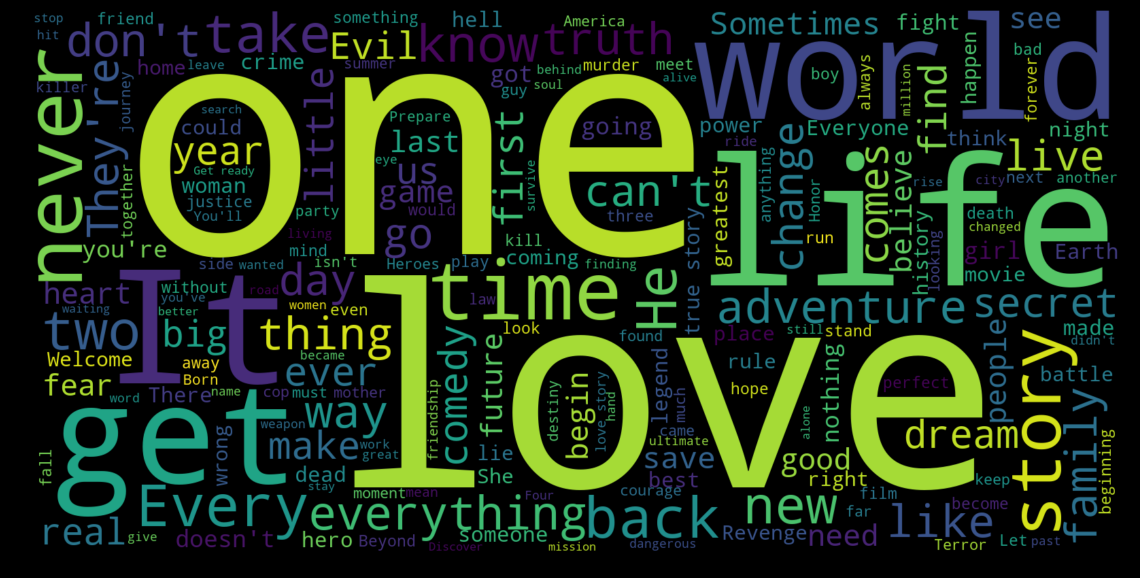

In [12]:
##Proving to myself here that the wordcloud for "taglines" would contain many vague words that would try to intrigue people.

wordcloud = whole2['tagline']
l = []
for i in wordcloud:
    new1 = str(i)
    new2 = new1.split()
    for i in new2:
        l.append(i)
string1 = ' '.join(l)
string1 = ''.join([c for c in string1 if c not in ('!', '?','.',',')])
#print(string1)
string1 = string1.replace('nan','')
print(string1.count('nan'))
sw = set(stopwords.words())
wordcloud = WordCloud(stopwords=sw,width=1600,height=800).generate(string1)
plt.figure(figsize =(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

0


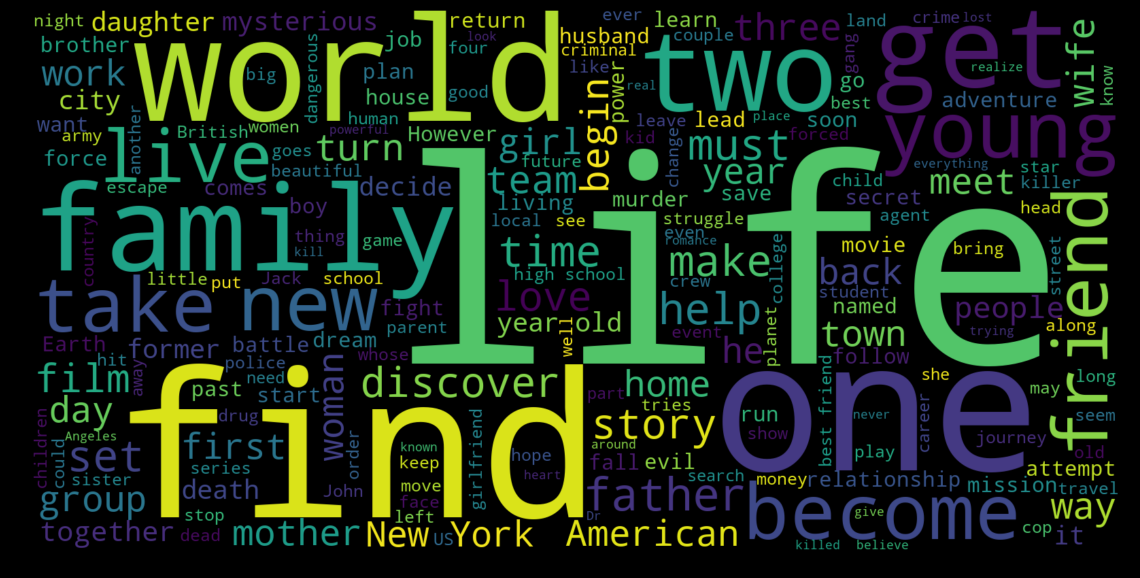

In [13]:
##Now I'm doing a wordcloud to see if the overviews resemble the taglines at all. I would suspect them to be more specific.

wordcloud = whole2['overview']
l = []
for i in wordcloud:
    new1 = str(i)
    new2 = new1.split()
    for i in new2:
        l.append(i)
string1 = ' '.join(l)
string1 = ''.join([c for c in string1 if c not in ('!', '?','.',',')])
#print(string1)
string1 = string1.replace('nan','')
print(string1.count('nan'))
sw = set(stopwords.words())
wordcloud = WordCloud(stopwords=sw,width=1600,height=800).generate(string1)
plt.figure(figsize =(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0356b66160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f034c612668>]], dtype=object)

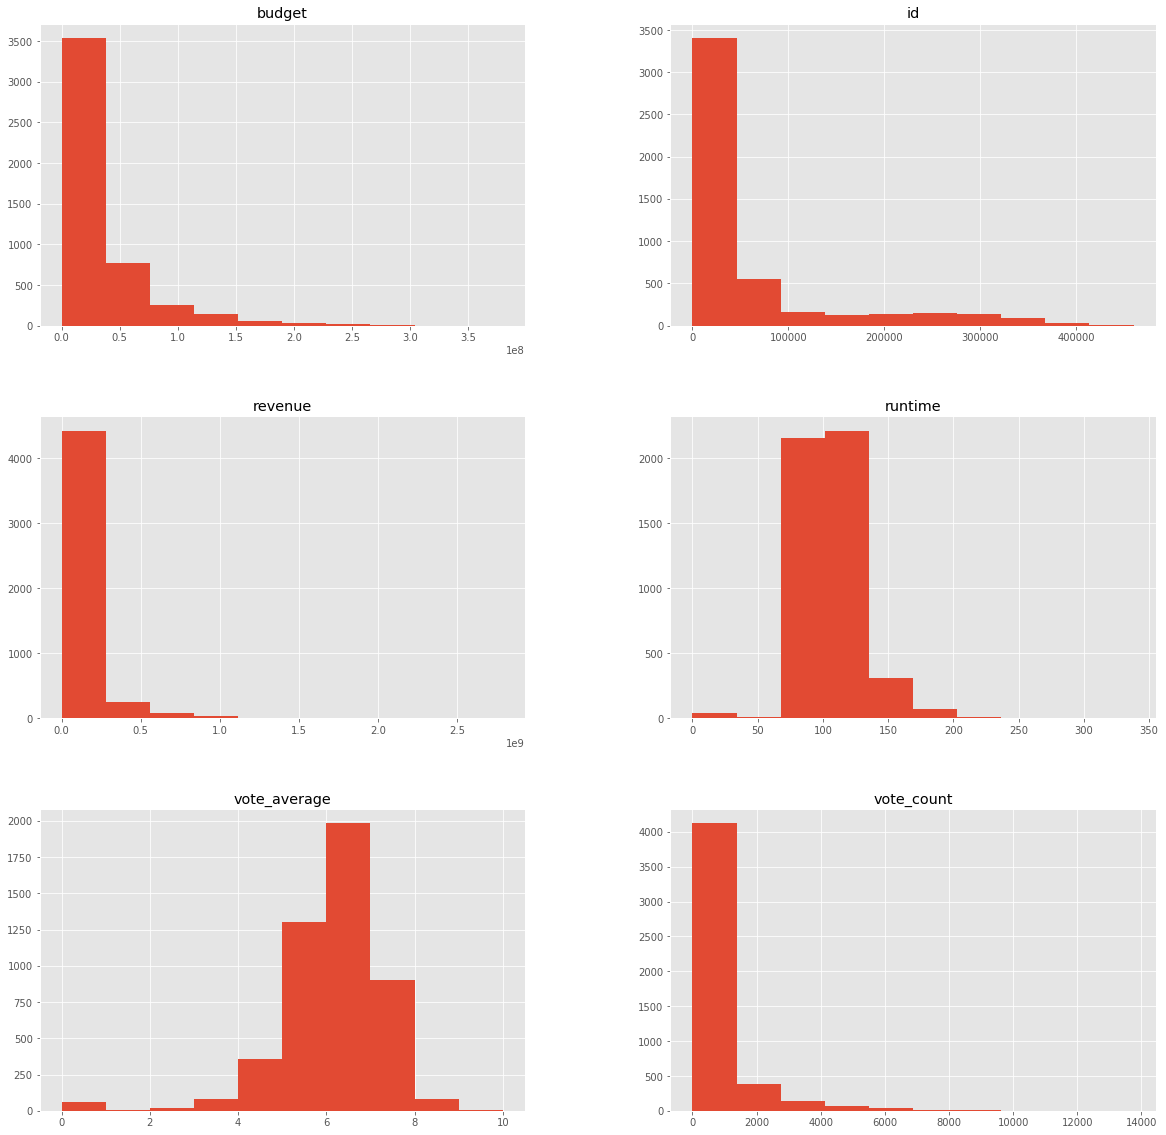

In [14]:
##Here we create histograms for our variables. I just wanted to see if there was anything interesting in their distributions.

fig = plt.figure(figsize = (20,20))
ax = fig.gca()

whole2.hist(ax=ax)

# We are now going to begin looking at the distributions of our variables against revenue and vote_average. 


In [15]:
print('Average revenue earned by the movies is', round(whole2['revenue'].mean(),4))
print('Average vote score earned by the movies is', round(whole2['vote_average'].mean(),4))
print('Average budget of the movies is', round(whole2['budget'].mean(),4))

Average revenue earned by the movies is 82260638.6517
Average vote score earned by the movies is 6.0922
Average budget of the movies is 29045039.8753


Text(0.5,1,'Residual Plot of Budget vs Revenue')

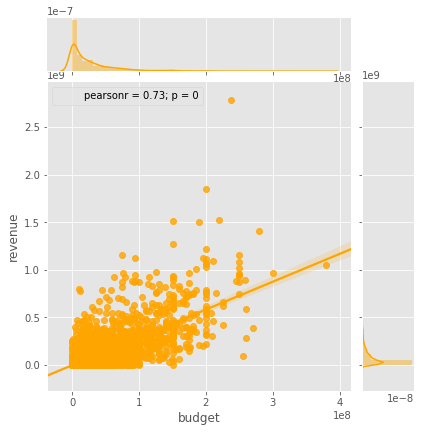

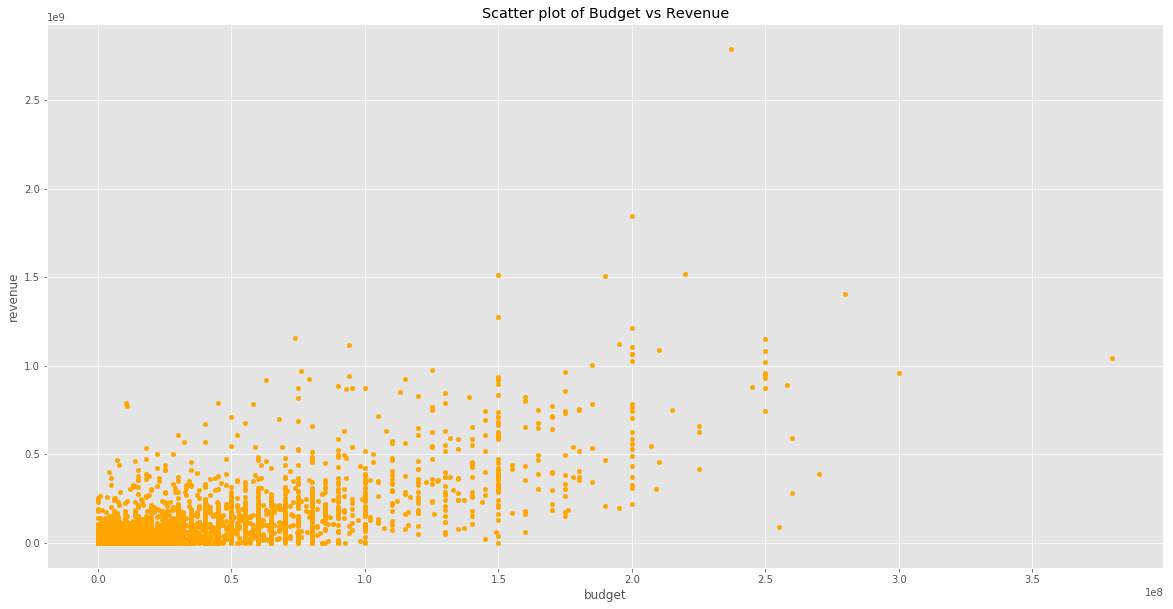

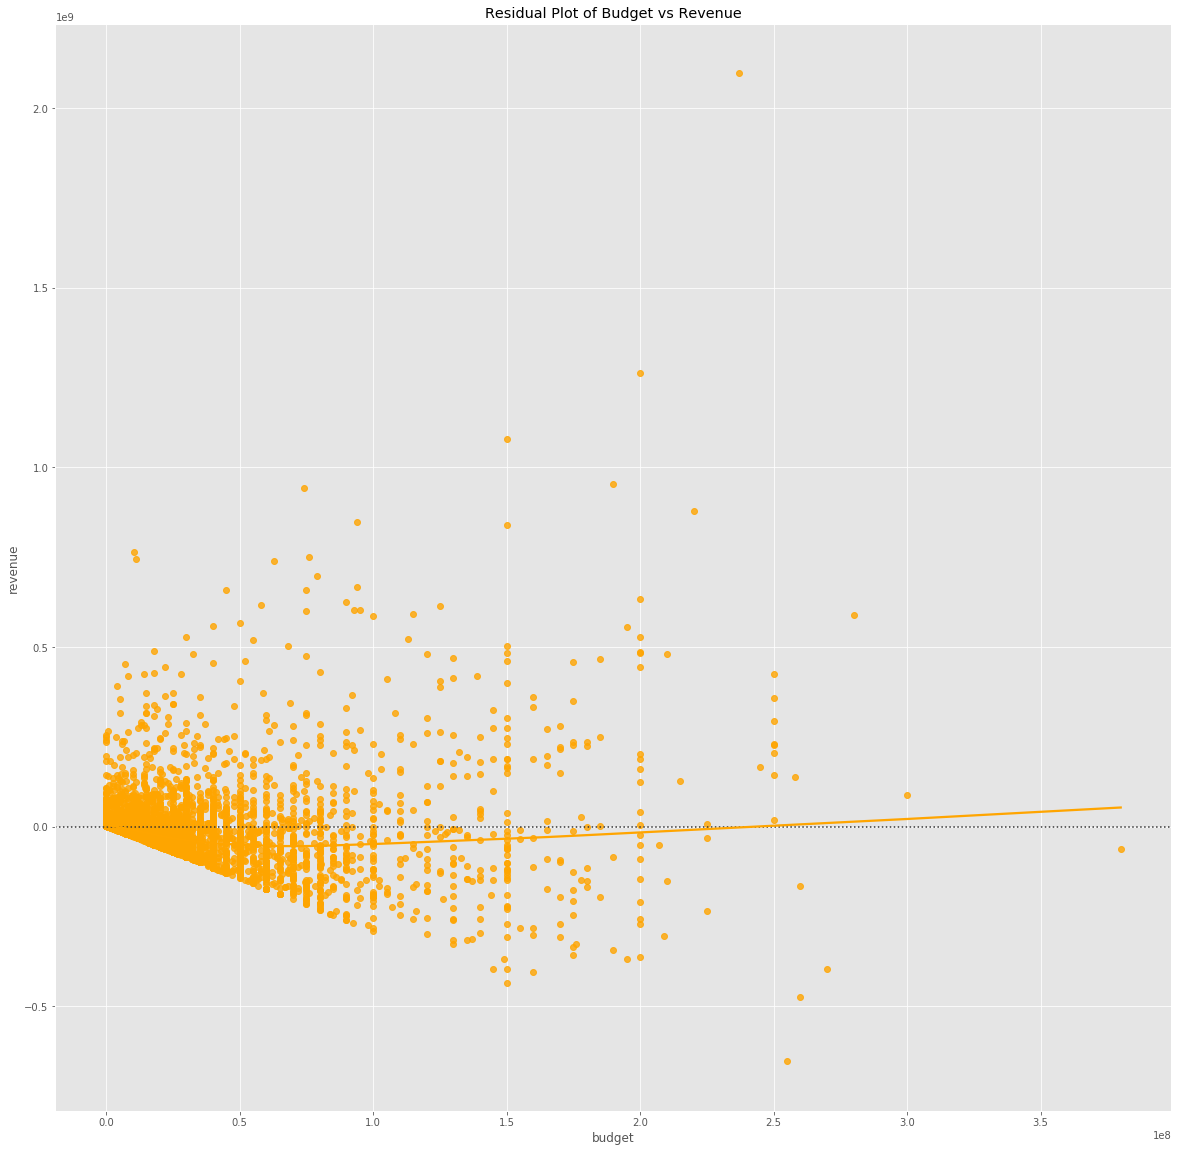

In [16]:
##BUDGET VS REVENUE


sbn.jointplot(x='budget', y='revenue', data = whole2, kind='reg', color = 'orange')
whole2.plot(kind='scatter', x='budget', y='revenue', figsize=(20,10), color = 'orange', title='Scatter plot of Budget vs Revenue')

fig, ax = plt.subplots(figsize=(20,20))
sbn.residplot('budget','revenue',data = whole2, lowess=True,color=('orange')).set_title('Residual Plot of Budget vs Revenue')


Text(0.5,1,'Scatter plot of Vote Average vs Revenue')

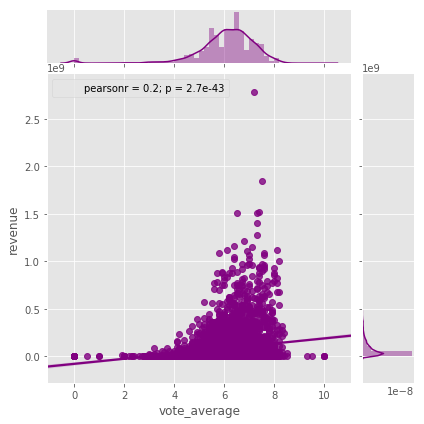

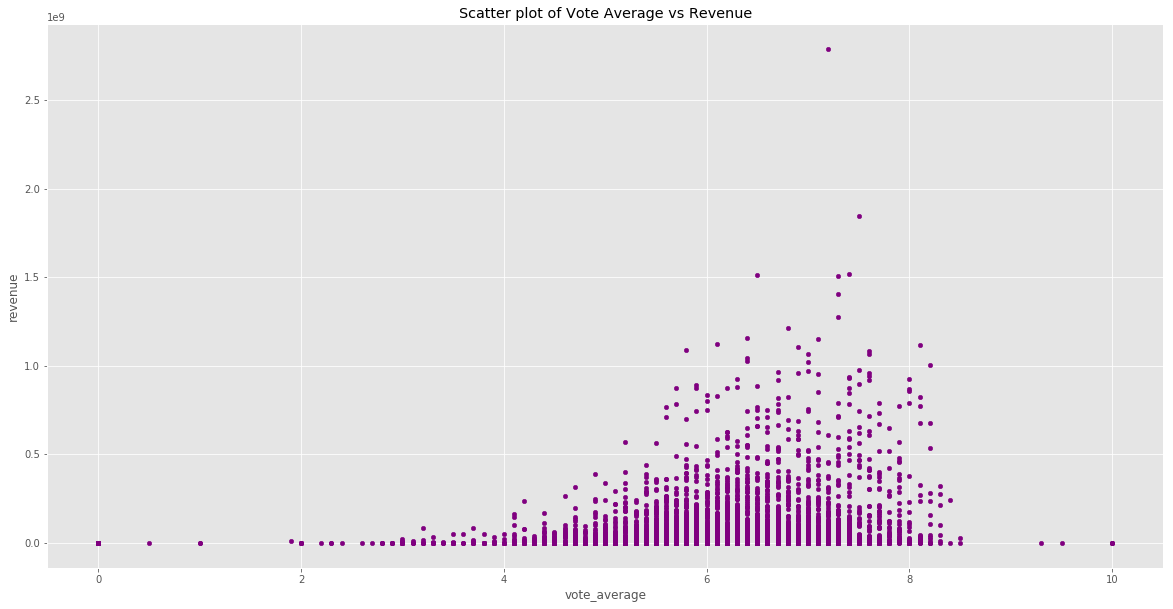

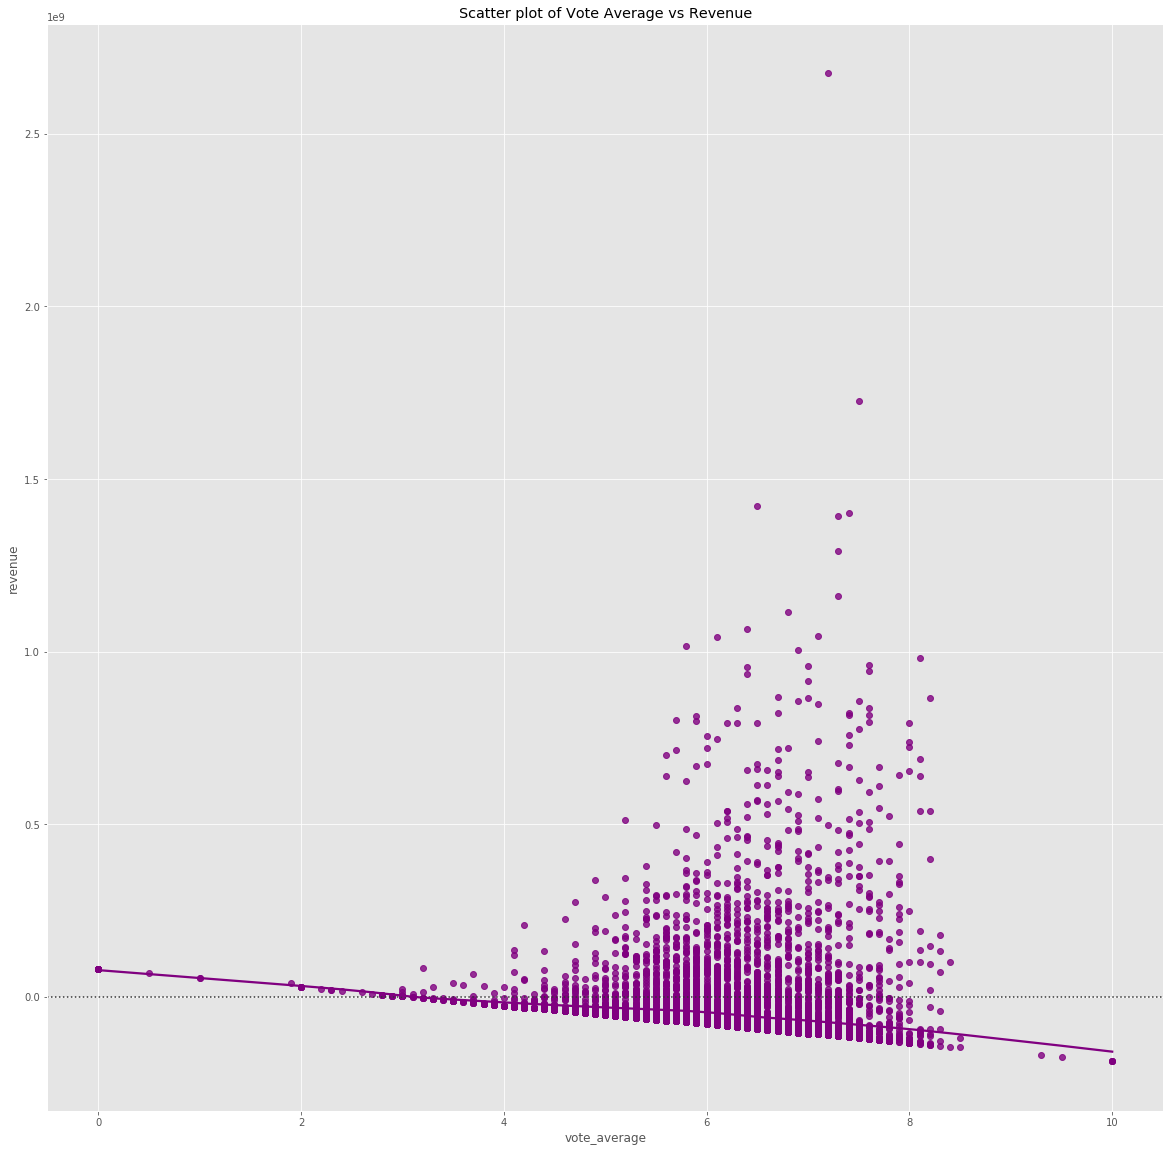

In [17]:
##REVENUE VS VOTE AVERAGE

sbn.jointplot(x='vote_average', y='revenue', data = whole2, kind='reg', color = 'purple')
whole2.plot(kind='scatter', x='vote_average', y='revenue', figsize=(20,10), color = 'purple', title='Scatter plot of Vote Average vs Revenue')

fig, ax = plt.subplots(figsize=(20,20))
sbn.residplot('vote_average','revenue',data = whole2, lowess=True,color=('purple')).set_title('Scatter plot of Vote Average vs Revenue')

Text(0.5,1,'Residual Plot of Runtime vs Revenue')

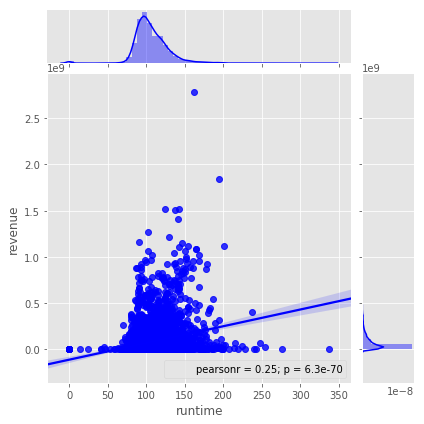

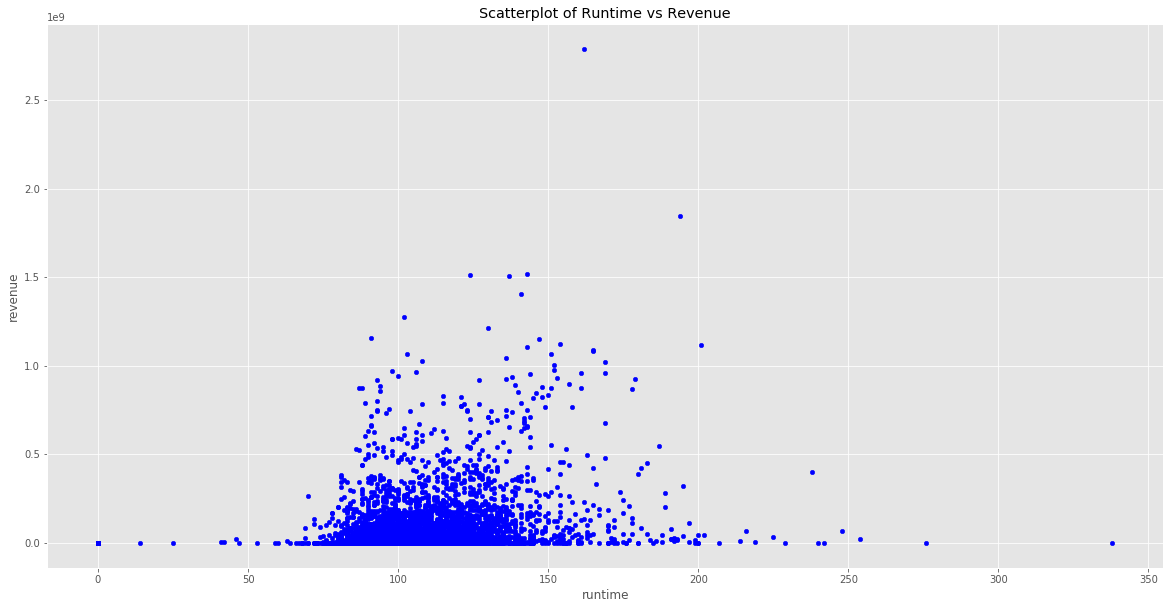

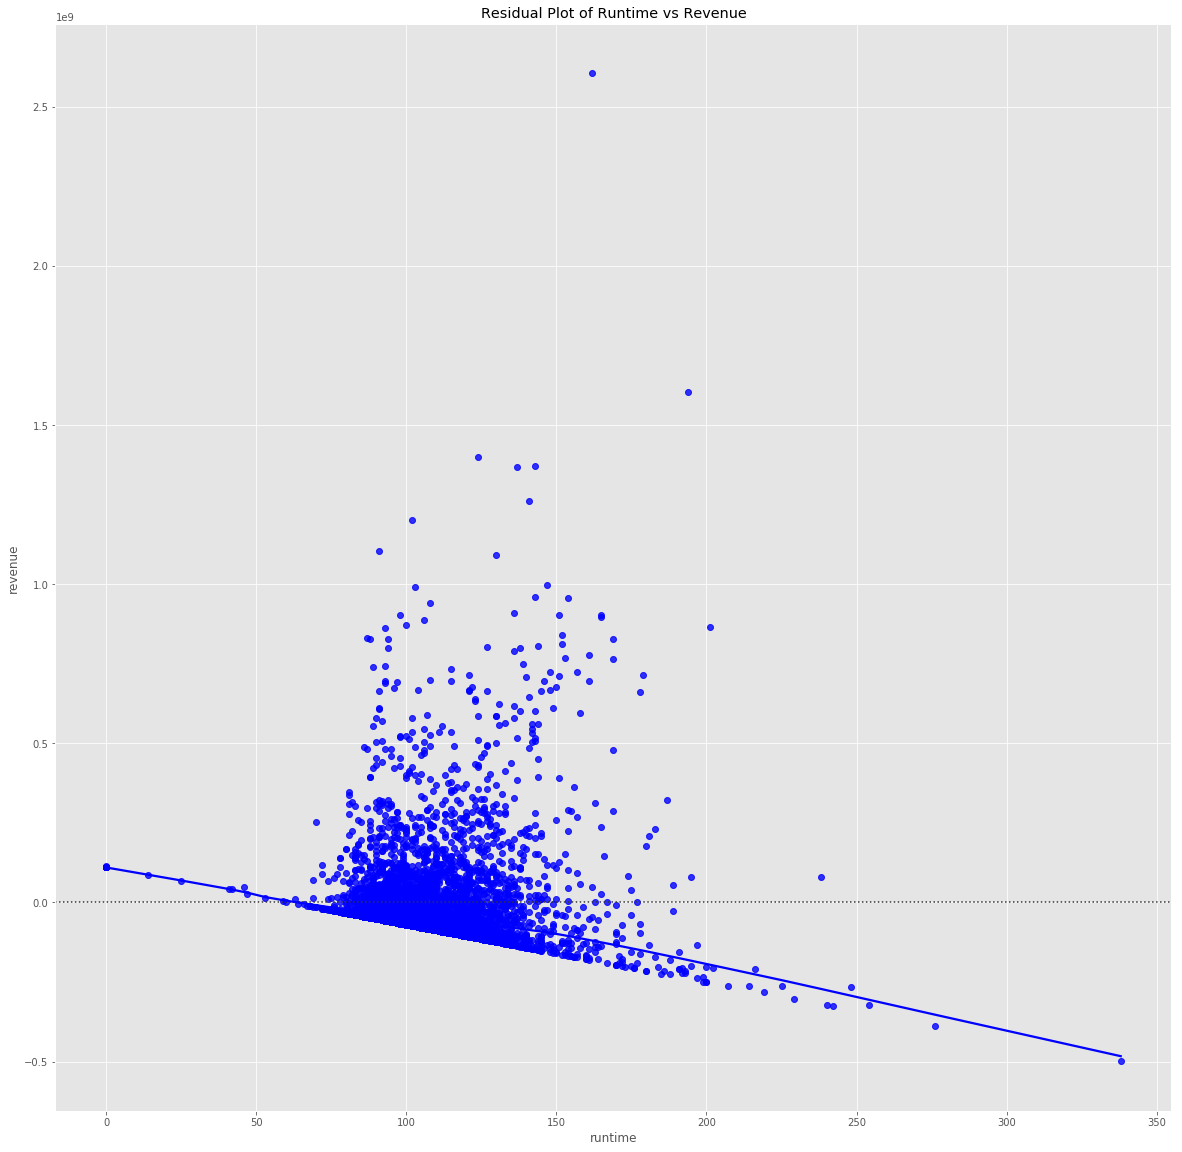

In [18]:
#RUNTIME VS REVENUE

sbn.jointplot(x='runtime', y='revenue', data = whole2, kind='reg', color=('blue'))
whole2.plot(kind='scatter', x='runtime', y='revenue', figsize=(20,10), color=('blue'), title=('Scatterplot of Runtime vs Revenue'))

fig, ax = plt.subplots(figsize=(20,20))
sbn.residplot('runtime','revenue',data = whole2, lowess=True,color=('blue')).set_title('Residual Plot of Runtime vs Revenue')

Text(0.5,1,'Residual plot of Budget vs Vote Average')

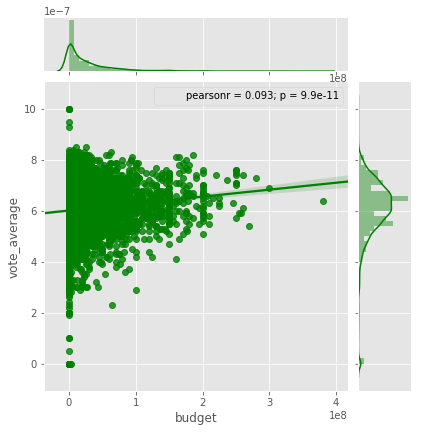

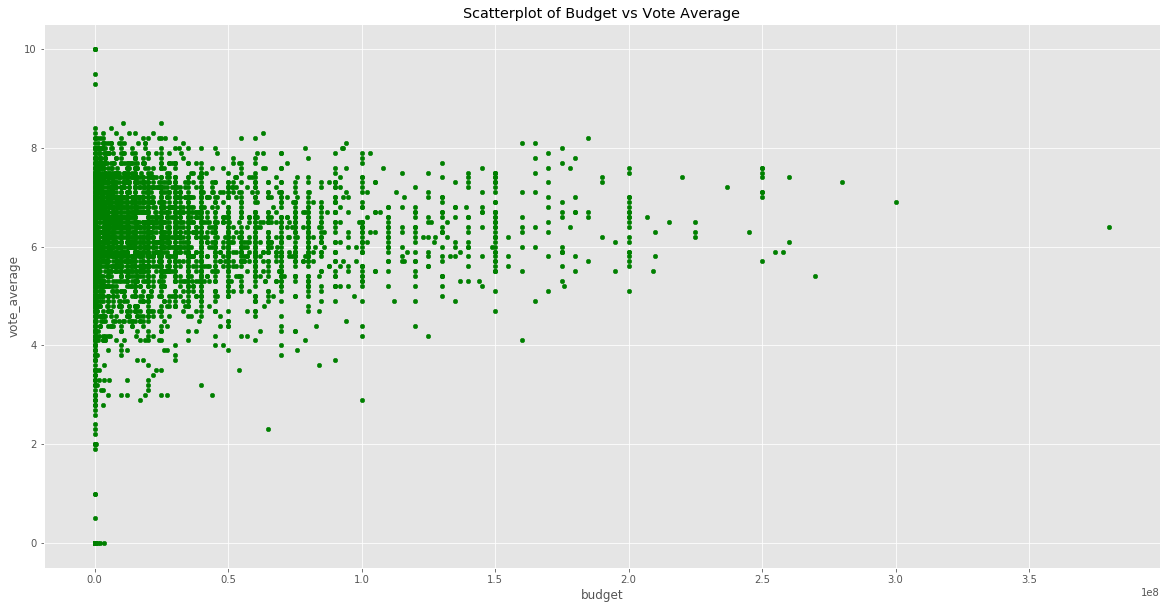

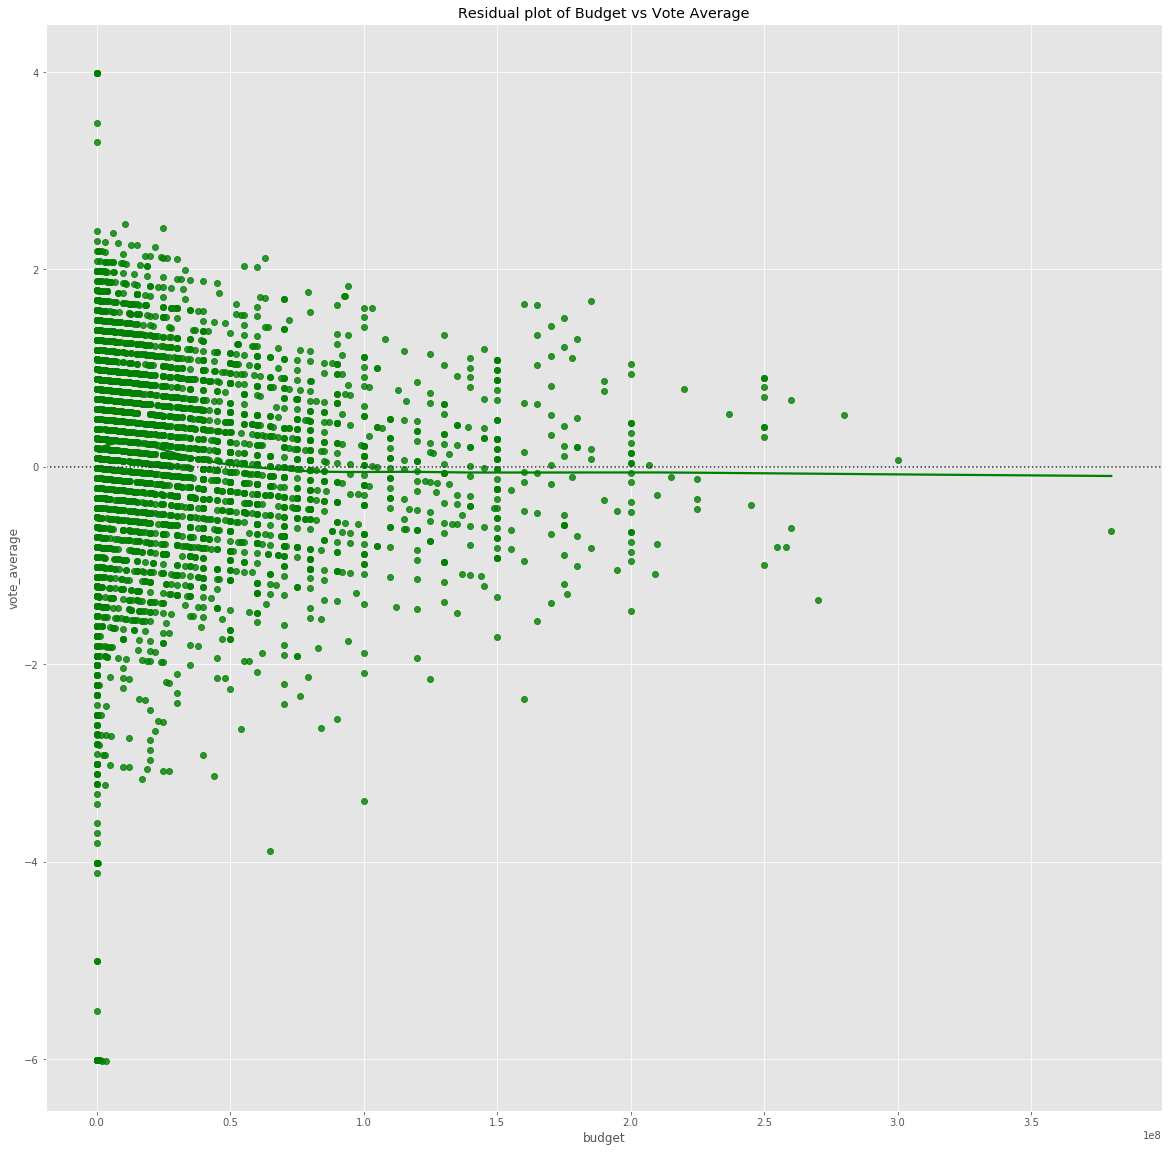

In [19]:
#BUDGET VS VOTE AVERAGE

sbn.jointplot(x='budget', y='vote_average', data = whole2, kind='reg', color=('green'))
whole2.plot(kind='scatter', x='budget', y='vote_average', figsize=(20,10), color=('green'), title=('Scatterplot of Budget vs Vote Average'))


fig, ax = plt.subplots(figsize=(20,20))
sbn.residplot('budget','vote_average',data = whole2, lowess=True,color=('green')).set_title('Residual plot of Budget vs Vote Average')

Text(0.5,1,'Residual plot of Runtime vs Vote Average')

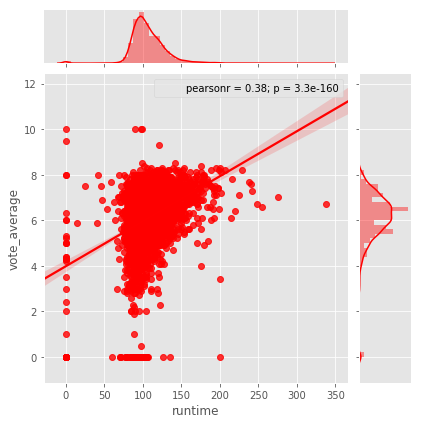

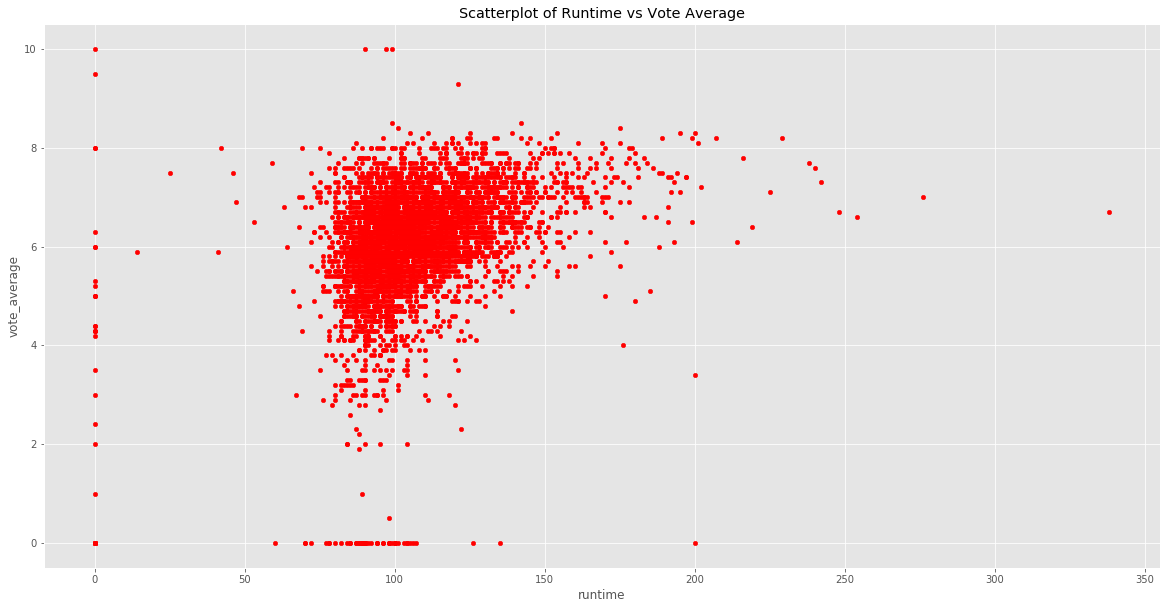

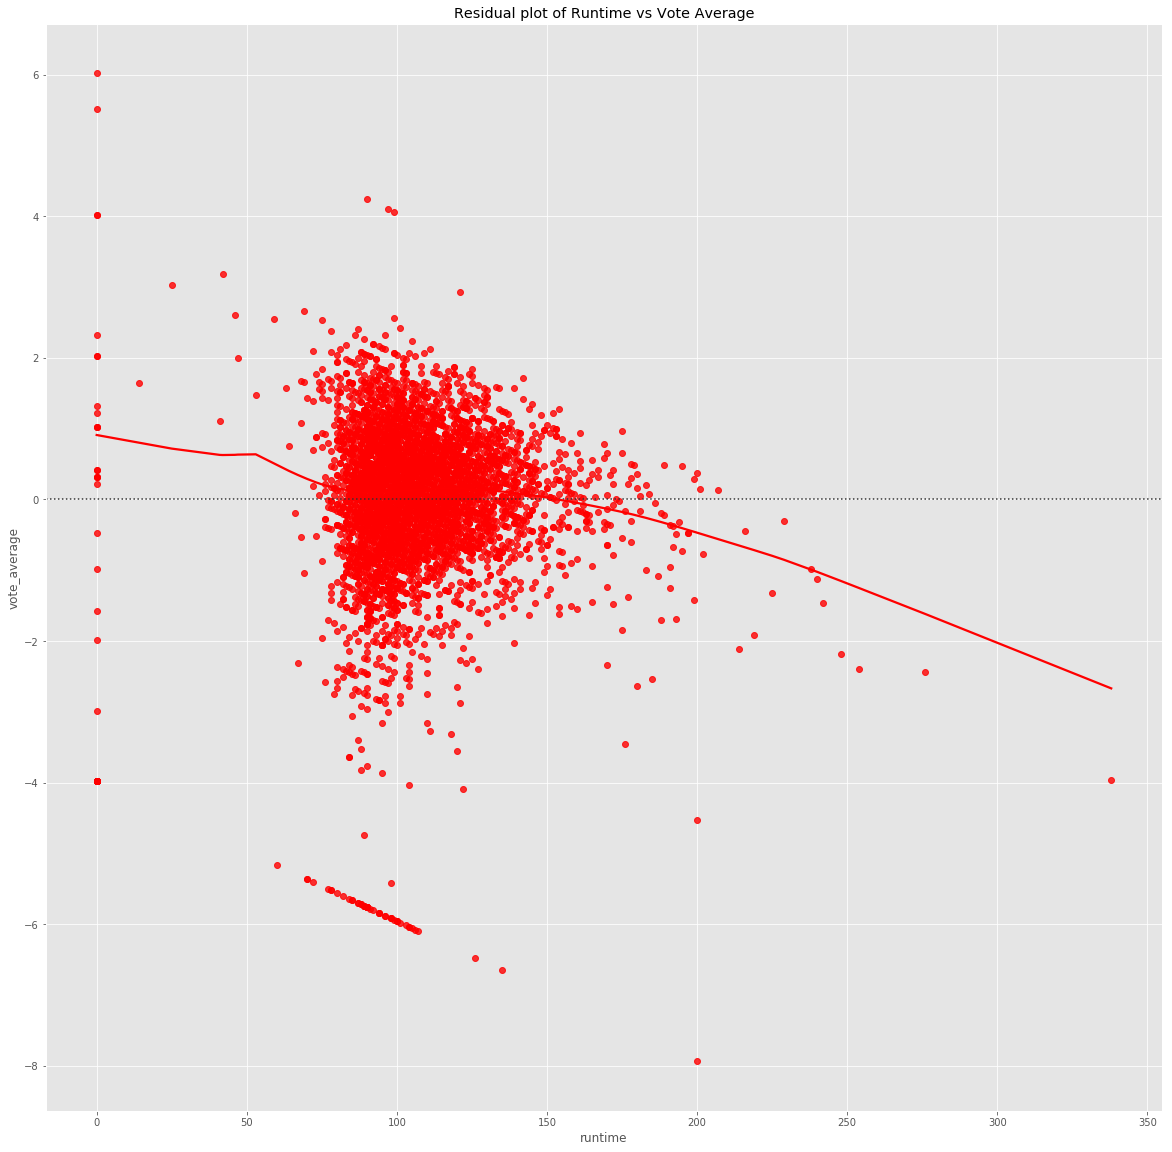

In [46]:
#RUNTIME VS VOTE AVERAGE

sbn.jointplot(x='runtime', y='vote_average', data = whole2, kind='reg', color=('red'))
whole2.plot(kind='scatter', x='runtime', y='vote_average', figsize=(20,10), color=('red'), title=('Scatterplot of Runtime vs Vote Average'))


fig, ax = plt.subplots(figsize=(20,20))
sbn.residplot('runtime','vote_average',data = whole2, lowess=True,color=('red')).set_title('Residual plot of Runtime vs Vote Average')

# We are now going to look into the genres of the movies.

In [21]:
whole_genre = whole2[['title','vote_average','revenue','runtime','genres']]
#whole_genre.head()

genre_dict = {}
adventure = []
fantasy = []
animation = []
drama = []
horror = []
action = []
comedy = []
history = []
western = []
thriller = []
crime = []
doc = []
sci_fi = []
mystery = []
music = []
romance = []
family = []
war = []
foreign = []
tv = []

whole_genre.head()
get_genre = whole_genre['genres']
for i in get_genre:
    single_line = i
    list2 = eval(single_line)
    #print(list2)
    
    for i in list2:
        genre_dict[i['id']] = i['name']
        
    for i in list2:
        if i['id'] == 12:
            adventure.append(i['name'])
            
    for i in list2:
        if i['id'] == 14:
            fantasy.append(i['name'])
            
    for i in list2:
        if i['id'] == 16:
            animation.append(i['name'])
            
    for i in list2:
        if i['id'] == 18:
            drama.append(i['name'])
            
    for i in list2:
        if i['id'] == 27:
            horror.append(i['name'])
            
    for i in list2:
        if i['id'] == 28:
            action.append(i['name'])
            
    for i in list2:
        if i['id'] == 35:
            comedy.append(i['name'])
            
    for i in list2:
        if i['id'] == 36:
            history.append(i['name'])
            
    for i in list2:
        if i['id'] == 37:
            western.append(i['name'])
            
    for i in list2:
        if i['id'] == 53:
            thriller.append(i['name'])
            
    for i in list2:
        if i['id'] == 80:
            crime.append(i['name'])
            
    for i in list2:
        if i['id'] == 99:
            doc.append(i['name'])
            
    for i in list2:
        if i['id'] == 878:
            sci_fi.append(i['name'])
            
    for i in list2:
        if i['id'] == 9648:
            mystery.append(i['name'])
            
    for i in list2:
        if i['id'] == 10402:
            music.append(i['name'])
            
    for i in list2:
        if i['id'] == 10749:
            romance.append(i['name'])
            
    for i in list2:
        if i['id'] == 10751:
            family.append(i['name'])
            
    for i in list2:
        if i['id'] == 10752:
            war.append(i['name'])
            
    for i in list2:
        if i['id'] == 10769:
            foreign.append(i['name'])
            
    for i in list2:
        if i['id'] == 10770:
            tv.append(i['name'])
            

            

genre_dict
#adventure

{12: 'Adventure',
 14: 'Fantasy',
 16: 'Animation',
 18: 'Drama',
 27: 'Horror',
 28: 'Action',
 35: 'Comedy',
 36: 'History',
 37: 'Western',
 53: 'Thriller',
 80: 'Crime',
 99: 'Documentary',
 878: 'Science Fiction',
 9648: 'Mystery',
 10402: 'Music',
 10749: 'Romance',
 10751: 'Family',
 10752: 'War',
 10769: 'Foreign',
 10770: 'TV Movie'}

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



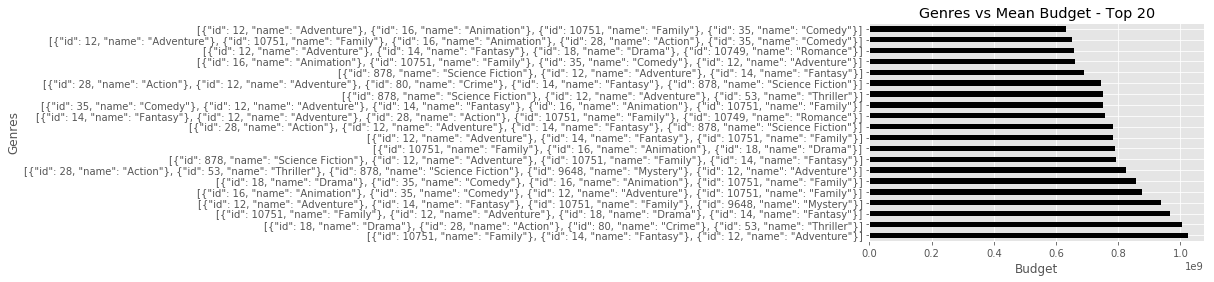

In [22]:
##We are looking at genre vs mean budget(here we are looking at top 5, but if you want more just change the numbers in the cell)
##I know this output is small so I created an image so we can better view it. (meanbudg)
whole_genre['genres']=whole_genre['genres'].str.replace('|','\n')
mean1 = whole_genre.groupby(['genres'])['revenue'].mean()
ax = mean1.nlargest(20).plot(kind='barh',title="Genres vs Mean Budget - Top 20",color=['black'])
ax.set_xlabel("Budget")
ax.set_ylabel("Genres")
plt.savefig("meanbudg.png", dpi=200)

In [23]:
total_genres = len(adventure)+len(fantasy)+len(animation)+len(drama)+len(horror)+len(action)+len(comedy)+len(history)+len(western)+len(thriller)
len(crime)+len(doc)+len(sci_fi)+len(mystery)+len(music)+len(romance)+len(family)+len(war)+len(foreign)+len(tv)


##Here we are just seeing how many movies fall into each genre and then the percentage that genre generates.

print('Adventure: ', len(adventure),'movies    ', round(100 *(len(adventure)/4803),4),'% of all the movies are adventure.')
print('Fantasy: ', len(fantasy),'movies    ', round(100 *(len(fantasy)/4803),4),'% of all the movies are fantasy.')
print('Animation: ', len(animation),'movies    ', round(100 *(len(animation)/4803),4),'% of all the movies are animation.')
print('Drama: ', len(drama),'movies    ', round(100 *(len(drama)/4803),4),'% of all the movies are drama.')
print('Horror: ', len(horror),'movies    ', round(100 *(len(horror)/4803),4),'% of all the movies are horror.')
print('Action: ', len(action),'movies    ', round(100 *(len(action)/4803),4),'% of all the movies are action.')
print('Comedy: ', len(comedy),'movies    ', round(100 *(len(comedy)/4803),4),'% of all the movies are comedy.')
print('History: ', len(history),'movies    ', round(100 *(len(history)/4803),4),'% of all the movies are history.')
print('Western: ', len(western),'movies    ', round(100 *(len(western)/4803),4),'% of all the movies are westerns.')
print('Thriller: ', len(thriller),'movies    ', round(100 *(len(thriller)/4803),4),'% of all the movies are thrillers.')
print('Crime: ', len(crime),'movies    ', round(100 *(len(crime)/4803),4),'% of all the movies are crime.')
print('Documentary: ', len(doc),'movies    ', round(100 *(len(doc)/4803),4),'% of all the movies are documentaries.')
print('Science Fiction: ', len(sci_fi),'movies    ', round(100 *(len(sci_fi)/4803),4),'% of all the movies are science fiction.')
print('Mystery: ', len(mystery),'movies    ', round(100 *(len(mystery)/4803),4),'% of all the movies are mystery.')
print('Music: ', len(music),'movies    ', round(100 *(len(music)/4803),4),'% of all the movies are music.')
print('Romance: ', len(romance),'movies    ', round(100 *(len(romance)/4803),4),'% of all the movies are romance.')
print('Family: ', len(family),'movies    ', round(100 *(len(family)/4803),4),'% of all the movies are family.')
print('War: ', len(war),'movies    ', round(100 *(len(war)/4803),4),'% of all the movies are war.')
print('Foreign: ', len(foreign),'movies    ', round(100 *(len(foreign)/4803),4),'% of all the movies are foreign.')
print('TV Movies: ', len(tv),'movies    ', round(100 *(len(tv)/4803),4),'% of all the movies are tv based.')
print(total_genres)


Adventure:  790 movies     16.4481 % of all the movies are adventure.
Fantasy:  424 movies     8.8278 % of all the movies are fantasy.
Animation:  234 movies     4.872 % of all the movies are animation.
Drama:  2297 movies     47.8243 % of all the movies are drama.
Horror:  519 movies     10.8057 % of all the movies are horror.
Action:  1154 movies     24.0267 % of all the movies are action.
Comedy:  1722 movies     35.8526 % of all the movies are comedy.
History:  197 movies     4.1016 % of all the movies are history.
Western:  82 movies     1.7073 % of all the movies are westerns.
Thriller:  1274 movies     26.5251 % of all the movies are thrillers.
Crime:  696 movies     14.4909 % of all the movies are crime.
Documentary:  110 movies     2.2902 % of all the movies are documentaries.
Science Fiction:  535 movies     11.1389 % of all the movies are science fiction.
Mystery:  348 movies     7.2455 % of all the movies are mystery.
Music:  185 movies     3.8518 % of all the movies are mu

# Now we are going to examine the release dates of the movies and see which months have the most movies. Maybe we can begin to examine which month is most popular as well.

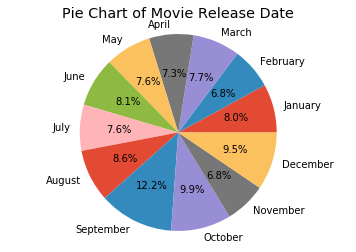

In [24]:
date_dist = whole2[['title','release_date','vote_average']]
jan=[]
jan_av=[]
feb=[]
feb_av=[]
mar=[]
mar_av=[]
april=[]
april_av=[]
may=[]
may_av=[]
june=[]
june_av=[]
july=[]
july_av=[]
aug=[]
aug_av=[]
sept=[]
sept_av=[]
octo=[]
octo_av=[]
nov=[]
nov_av=[]
dec=[]
dec_av=[]

#print(date_dist)
for i in date_dist['release_date']:
    if type(i) == float:
        del(i)
    else:
        d=datetime.strptime(i, '%Y-%m-%d')             #d is of type datetime
    #    print(d)
        month = d.month                                 #month is of type interger
        month = str(month)                              #we make month a string so that we know everything is a string
    #    print(month)
        if month == '1':
            jan.append(month)
        elif month == '2':
            feb.append(month)
        elif month == '3':
            mar.append(month)
        elif month == '4':
            april.append(month)
        elif month == '5':
            may.append(month)
        elif month == '6':
            june.append(month)
        elif month == '7':
            july.append(month)
        elif month == '8':
            aug.append(month)
        elif month == '9':
            sept.append(month)
        elif month == '10':
            octo.append(month)
        elif month == '11':
            nov.append(month)
        elif month == '12':
            dec.append(month) 
            

january = len(jan)
february = len(feb)
march = len(mar)
april = len(april)
may = len(may)
june = len(june)
july = len(july)
august = len(aug)
september = len(sept)
october = len(octo)
november = len(nov)
december = len(dec)


labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
values = [january,february,march,april,may,june,july,august,september,october,november,december]

plt.pie(values, labels = labels, autopct='%1.1f%%')
plt.title('Pie Chart of Movie Release Date')
plt.axis('equal')
plt.show()


It seems movies in December tend to have the highest vote average!


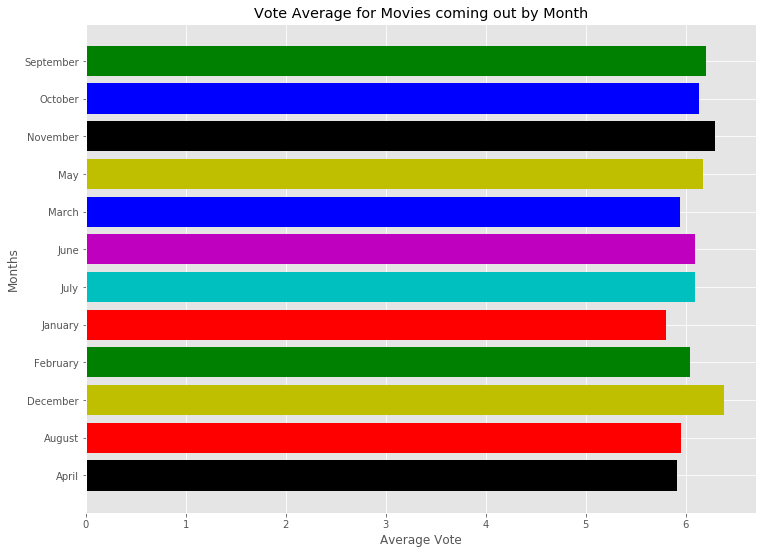

In [60]:
whole3 = whole2[['title','vote_average','release_date']]
for i in range(4803):
    date = whole3['release_date'][i]
    date = str(date)
    date = date.split('-')
    try:
        month = date[1]
    except IndexError:
        month = 'null'
    #print(month)
    if month == '01':
        jan_av.append(whole3['vote_average'][i])
    elif month == '02':
        feb_av.append(whole3['vote_average'][i])
    elif month == '03':
        mar_av.append(whole3['vote_average'][i])
    elif month == '04':
        april_av.append(whole3['vote_average'][i])
    elif month == '05':
        may_av.append(whole3['vote_average'][i])
    elif month == '06':
        june_av.append(whole3['vote_average'][i])
    elif month == '07':
        july_av.append(whole3['vote_average'][i])
    elif month == '08':
        aug_av.append(whole3['vote_average'][i])
    elif month == '09':
        sept_av.append(whole3['vote_average'][i])
    elif month == '10':
        octo_av.append(whole3['vote_average'][i])
    elif month == '11':
        nov_av.append(whole3['vote_average'][i])
    elif month == '12':
        dec_av.append(whole3['vote_average'][i])
        

jan_vote_av = np.mean(jan_av)
jan_vote_av
feb_vote_av = np.mean(feb_av)
feb_vote_av
mar_vote_av = np.mean(mar_av)
mar_vote_av
april_vote_av = np.mean(april_av)
april_vote_av
may_vote_av = np.mean(may_av)
may_vote_av
june_vote_av = np.mean(june_av)
june_vote_av
july_vote_av = np.mean(july_av)
july_vote_av
aug_vote_av = np.mean(aug_av)
aug_vote_av
sept_vote_av = np.mean(sept_av)
sept_vote_av
octo_vote_av = np.mean(octo_av)
octo_vote_av
nov_vote_av = np.mean(nov_av)
nov_vote_av
dec_vote_av = np.mean(dec_av)
dec_vote_av

my_colors = 'rgbkymc'
month_vote_averages = [jan_vote_av,feb_vote_av,mar_vote_av,april_vote_av,may_vote_av,june_vote_av,july_vote_av,aug_vote_av,sept_vote_av,octo_vote_av,nov_vote_av,dec_vote_av]

plt.barh(labels,month_vote_averages,align='center',color=my_colors)
plt.title("Vote Average for Movies coming out by Month")
plt.ylabel('Months')
plt.xlabel('Average Vote')
fig_size[0] = 12
fig_size[1] = 9

if month_vote_averages[10]<month_vote_averages[11]:
    print("It seems movies in December tend to have the highest vote average!")

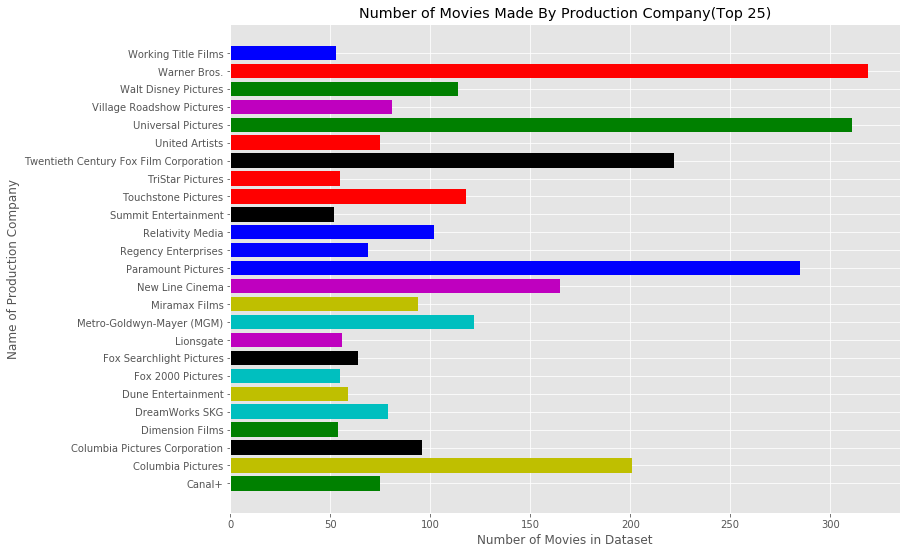

[12.0, 9.0]

In [61]:
prod_company = whole2[['title','production_companies','revenue','vote_average']]
comp_dict = {}
comp_list = []
prod_company.head()
get_comp = prod_company['production_companies']
for i in get_comp:
    single_line = i
    list2 = eval(single_line)
    for i in list2:
        comp_list.append(i['name'])
        comp_dict[i.get('id')] = i.get('name')
occur_comp = Counter(comp_list)
top25_comp = occur_comp.most_common(25)

names = [top25_comp[item][0] for item in range(len(top25_comp))]
values = [top25_comp[item][1] for item in range(len(top25_comp))]

my_colors = 'rgbkymc'
plt.barh(names, values, align = 'center', color = my_colors)

plt.title('Number of Movies Made By Production Company(Top 25)')
plt.xlabel('Number of Movies in Dataset')
plt.ylabel('Name of Production Company')
plt.grid(True)

plt.show()

fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"]

# print(type(occur_comp))
#print(comp_dict)
#len(comp_dict)